### The Logistic Regression Classification involves the following tasks:

Step 1: Quick Overview of the Data Structure

Step 2: Prepare Dataset (Training, Validation, and Test Data)

Step 3: Image Preprocessing

Step 4: Baseline Neural Network Model

Step 5: Model Selection and Training

Step 6: Evalute Models and Feature Importance on the Test Data

Import libraries

In [1]:
import os
import pandas as pd
import numpy as np

%matplotlib inline 
import matplotlib.pyplot as plt

Import the dataset 

In [2]:
x = np.load('data/ps4_trainvalid_images.npy')
labels=pd.read_csv('data/ps4_trainvalid_labels.csv')

### Step 1: Quick Overview of the Data Structure

Print the shape of the training dataset. In total, we got around 13K data points for the training data. 

Based on the shape of numpy, we see that we get 13260 images, each of them has 64*64 dimensions and one channel (black-and-white channel)

In [3]:
print(x.shape)
print(x.dtype)

(13260, 64, 64, 1)
uint8


Print the details of the training array.

In [143]:
x

array([[[[  2],
         [  2],
         [  2],
         ...,
         [  1],
         [ 48],
         [  0]],

        [[  2],
         [  2],
         [  2],
         ...,
         [  1],
         [ 13],
         [ 40]],

        [[  2],
         [  2],
         [  2],
         ...,
         [  1],
         [  1],
         [  1]],

        ...,

        [[ 87],
         [122],
         [149],
         ...,
         [ 87],
         [ 40],
         [  2]],

        [[ 86],
         [118],
         [145],
         ...,
         [ 76],
         [ 29],
         [  1]],

        [[ 90],
         [124],
         [148],
         ...,
         [ 65],
         [ 14],
         [  2]]],


       [[[  2],
         [  2],
         [  2],
         ...,
         [  0],
         [ 49],
         [  0]],

        [[  2],
         [  2],
         [  1],
         ...,
         [  0],
         [ 13],
         [ 40]],

        [[  2],
         [  2],
         [  1],
         ...,
         [  0],
         [

Divide data points by 255 to reshape the training data.

In [4]:
x_shaped=x.reshape(-1,64,64)/255.0

Check the label data 

In [6]:
labels.head()

,Id,Label
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


Convert label data to numpy array for future processing

In [7]:
y = labels.Label.to_numpy() 
y

array([0, 0, 0, ..., 0, 2, 0])

Check for the frequency and percentage of three types of x-ray images

In [8]:
import collections

count = collections.Counter(y).items()
percentages = {x: float(z) / len(y) * 100 for x, z in count}
collections.Counter(y),percentages

(Counter({0: 10506, 1: 2372, 2: 382}),
 {0: 79.23076923076923, 1: 17.88838612368024, 2: 2.880844645550528})

Plot three types of x-ray images (0: Healthy, 1: Pre-existing condition, 2: Effusion/ Mass) (DSCI552 Lecture, 2021)

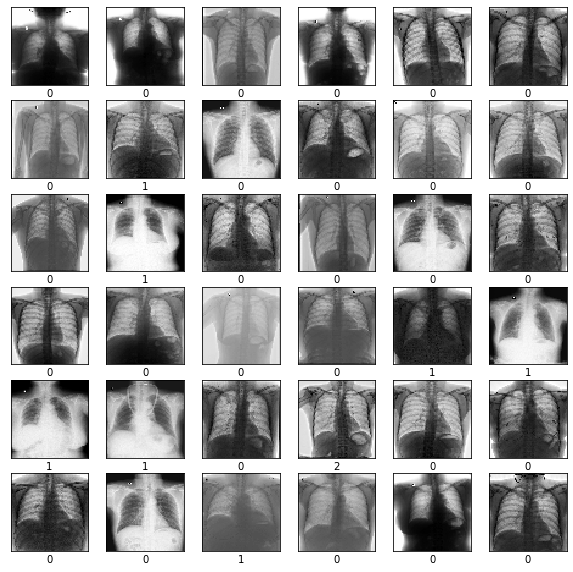

In [9]:
plt.figure(figsize=(10,10))
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_shaped[i],cmap=plt.cm.binary)
    plt.xlabel(y[i])
plt.show()

### Step 2: Prepare Dataset (Training, Validation, and Test Data)

Use shuffling index method to randomly split data into training, validation and test datasets with the ratio of 8:1:1 (DSC1552 Lecture, 2021)


Ceate random indices for image data points

In [10]:
N=len(x)
shuffled_indices = np.random.permutation(N)

Split indices into training, validation and test datasets with the ratio of 8:1:1. 

In [11]:
train_indices=shuffled_indices[:int(N*0.8)]
valid_indices=shuffled_indices[int(N*0.8):int(N*0.9)]
test_indices=shuffled_indices[int(N*0.9):]

Split data into training, validation and test datasets based on the suffled indices accordingly.

In [12]:
train_x=x[train_indices]
valid_x=x[valid_indices]
test_x=x[test_indices]

train_y=y[train_indices]
valid_y=y[valid_indices]
test_y=y[test_indices]

Check the shapes of training, validation and test datasets and their labels respectively

In [16]:
train_x.shape, valid_x.shape, test_x.shape,train_y.shape,valid_y.shape,test_y.shape

((10608, 64, 64, 1),
 (1326, 64, 64, 1),
 (1326, 64, 64, 1),
 (10608,),
 (1326,),
 (1326,))

Verify the percentage distribution of training, validation and test data based on three types of x-ray images.

According to the percentage distribution of training, validation and test data datasets, we are confident that our shuffled sampling has similar distribution with our original image dataset.

In [17]:
count_train_y = collections.Counter(train_y).items()
percentages_train = {x: float(z) / len(train_y) * 100 for x, z in count_train_y}
count_valid_y = collections.Counter(valid_y).items()
percentages_valid = {x: float(z) / len(valid_y) * 100 for x, z in count_valid_y}
count_test_y = collections.Counter(test_y).items()
percentages_test = {x: float(z) / len(test_y) * 100 for x, z in count_test_y}
collections.Counter(train_y),percentages_train,collections.Counter(valid_y),percentages_valid,collections.Counter(test_y),percentages_test

(Counter({0: 8403, 1: 1898, 2: 307}),
 {0: 79.21380090497738, 1: 17.892156862745097, 2: 2.8940422322775263},
 Counter({0: 1071, 2: 40, 1: 215}),
 {0: 80.76923076923077, 2: 3.0165912518853695, 1: 16.21417797888386},
 Counter({0: 1032, 2: 35, 1: 259}),
 {0: 77.82805429864254, 2: 2.6395173453996983, 1: 19.53242835595777})

### Step 3: Image Preprocessing

Copy the original training data again for the future data processing (Geron, 2019)

In [18]:
x_copy=x.copy()

#### Data Augmentation

In [23]:
import tensorflow as tf
from tensorflow import keras

In the data augmentation step, we will only apply the data transformation to the training data. We will first split the training data by three different image classes accordingly. 

In [19]:
label1_x=[]
label1_y=[]
label2_x=[]
label2_y=[]
label0_x=[]
label0_y=[]

for i in range(len(train_y)):
    if train_y[i]==1:
        label1_y.append(train_y[i])
        label1_x.append(train_x[i])
    elif train_y[i]==2:
        label2_y.append(train_y[i])
        label2_x.append(train_x[i])
    else:
        label0_y.append(train_y[i])
        label0_x.append(train_x[i])
        
label1_x=np.asarray(label1_x)
label1_y=np.asarray(label1_y)
label2_x=np.asarray(label2_x) 
label2_y=np.asarray(label2_y)
label0_x=np.asarray(label0_x) 
label0_y=np.asarray(label0_y)

Check the shape of each class to confirm that there is no human error during the processing

In [20]:
label1_x.shape,label1_y.shape,label2_x.shape,label2_y.shape,label0_y.shape,label0_y.shape

((1898, 64, 64, 1), (1898,), (307, 64, 64, 1), (307,), (8403,), (8403,))

Check the distribution of each class to confirm that there is no human error during the processing. 

From the distribution, we see that the training dataset is dominated by class 0, which are the healthy cases, while the dataset is unbalance for both class 1 (pre-existing conditions) and class 2 (effusion/ mass). Class 2 is extremely deficient in the training dataset.

In [21]:
collections.Counter(label1_y),collections.Counter(label2_y),collections.Counter(label0_y)

(Counter({1: 1898}), Counter({2: 307}), Counter({0: 8403}))

TensorFlow Documentation: https://www.tensorflow.org/api_docs/python/tf/image

Inspired by TensorFlow Documentation (2020), I used randomized horizontal flip and contrast transformation for the data augmentation. Specifically, the data augmentation was conducted in the following orders: 

1.	 Horizontal Flip Randomization

Horizontal flip has been selected for the first round of augmentation because flip is one of the most common image transformation methods. Additionally, it is realistic to have a mirror image of x-ray by switching the order of left and right lung when doctors are collecting the x-ray images. 
Vertical flip was not used because it does not make sense to receive an image with a reverse lung during the data collection. The flip transformation is randomized to generate images that are more likely to simulate the manually collected images. 

2.	Contrast Randomization

In the image illustration step, I saw that x-ray images could vary in their brightness and contrast even when they belong to different image classes. It is also common to receive x-ray images with variation in contrast due to different lighting conditions at the hospital. 
Brightness was not conducted for the data augmentation because this transformation will convert all images to an entire white image when the training data have a low resolution, this pattern persists even with tiny altering is applied by using a small brightness ratio. 
Hue and saturation were not selected because they can only be applied to images with three channels, which are the color images.


#### Horizontal Flip Randomization

Transform the images through flipping  

In [24]:
label1_x_flip=tf.image.random_flip_left_right(label1_x, 42).numpy().tolist()
label1_x_flip=np.asarray(label1_x_flip)


label2_x_flip=tf.image.random_flip_left_right(label2_x, 42).numpy().tolist()
label2_x_flip=np.asarray(label2_x_flip)

label1_x_flip.shape,label2_x_flip.shape

((1898, 64, 64, 1), (307, 64, 64, 1))

Illustrate the first nine images of the training data after flipping and compare them with their original versions. 

Flipped images


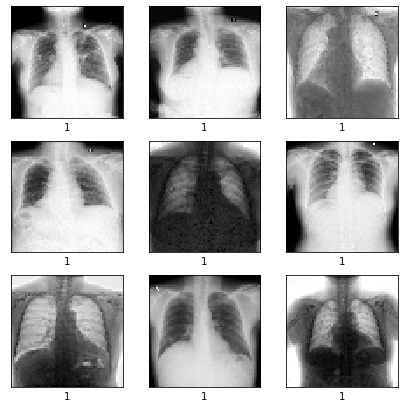

Original images


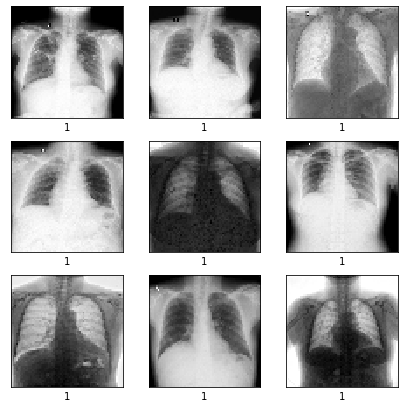

In [25]:
label1_x_flip_shaped=label1_x_flip.reshape(-1,64,64)/255.0
label1_x_shaped=label1_x.reshape(-1,64,64)/255.0

print('Flipped images')
plt.figure(figsize=(7,7))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(label1_x_flip_shaped[i],cmap=plt.cm.binary)
    plt.xlabel(label1_y[i])
plt.show()
print('Original images')
plt.figure(figsize=(7,7))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(label1_x_shaped[i],cmap=plt.cm.binary)
    plt.xlabel(label1_y[i])
plt.show()

Concatenate the transformed images with the original images from class 2 and class 1 for data augmentation. 

In [26]:
label1_x_2=np.concatenate((label1_x, label1_x_flip))
label1_y_2=np.concatenate((label1_y, label1_y))
label2_x_2=np.concatenate((label2_x, label2_x_flip))
label2_y_2=np.concatenate((label2_y, label2_y))
label1_x_2.shape,label1_y_2.shape,label2_x_2.shape,label2_y_2.shape

((3796, 64, 64, 1), (3796,), (614, 64, 64, 1), (614,))

#### Contrast Randomization 

Transform the images through randomizing contrast scales  

In [27]:
label1_x_contrast=tf.image.random_contrast(label1_x_2, 0.5,1.5,42).numpy().tolist()
label1_x_contrast=np.asarray(label1_x_contrast)


label2_x_contrast=tf.image.random_contrast(label2_x_2, 0.5,1.5,42).numpy().tolist()
label2_x_contrast=np.asarray(label2_x_contrast)

label1_x_contrast.shape,label2_x_contrast.shape

((3796, 64, 64, 1), (614, 64, 64, 1))

Illustrate the first nine images of the training data after randomizing the contrast.

Contrast images


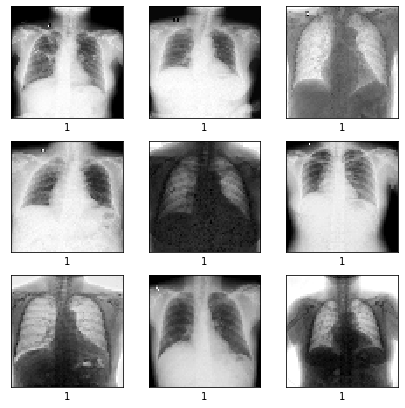

In [28]:
label1_x_contrast_shaped=label1_x_contrast.reshape(-1,64,64)/255.0
label1_x_shaped=label1_x.reshape(-1,64,64)/255.0

print('Contrast images')
plt.figure(figsize=(7,7))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(label1_x_contrast_shaped[i],cmap=plt.cm.binary)
    plt.xlabel(label1_y_2[i])
plt.show()

Concatenate the transformed images with the augumentated data of class 2 and class 1 in the last step. 

After two rounds of data augmentation, Class 1 finally reaches 7592 images, which is closer to the 8403 images in Class 0.Therefore, I generated a more balanced data between Class 1 and 0 by performing data augmentation.

In [29]:
label1_x_4=np.concatenate((label1_x_2, label1_x_contrast))
label1_y_4=np.concatenate((label1_y_2, label1_y_2))
label2_x_4=np.concatenate((label2_x_2, label2_x_contrast))
label2_y_4=np.concatenate((label2_y_2, label2_y_2))
label1_x_4.shape,label1_y_4.shape,label2_x_4.shape,label2_y_4.shape

((7592, 64, 64, 1), (7592,), (1228, 64, 64, 1), (1228,))

#### Additional Data Augumentation for Class 2 Images

Additional data augumentation is needed for class 2 due to its deficiency. 

Apply one more round of flip transformation to class 2 for data augumentation. 

In [30]:
label2_x_flip=tf.image.random_flip_left_right(label2_x_4, 42).numpy().tolist()
label2_x_flip=np.asarray(label2_x_flip)

label2_x_flip.shape

(1228, 64, 64, 1)

Concatenate the transformed data with the augumentated class 2 images. 

In [31]:
label2_x_8=np.concatenate((label2_x_4, label2_x_flip))
label2_y_8=np.concatenate((label2_y_4, label2_y_4))
label2_x_8.shape,label2_y_8.shape

((2456, 64, 64, 1), (2456,))

Apply two more rounds of contrast transformation (high contrast and low constrast)to class 2 for data augumentation. 

In [32]:
label2_x_lowcontrast=tf.image.random_contrast(label2_x_8, 0.2,1.0,42).numpy().tolist()
label2_x_lowcontrast=np.asarray(label2_x_lowcontrast)
label2_x_highcontrast=tf.image.random_contrast(label2_x_8, 1.0,3.0,42).numpy().tolist()
label2_x_highcontrast=np.asarray(label2_x_highcontrast)

label2_x_lowcontrast.shape,label2_x_highcontrast.shape

((2456, 64, 64, 1), (2456, 64, 64, 1))

After multiple rounds of data augmentaton, class 2 finally reaches 7368 images, which is closer to the 8403 images in class 0 and 7592 images in class 1.Therefore, we receive a more balanced data by performing data augumentation. 

In [33]:
label2_x_24=np.concatenate((label2_x_8, label2_x_lowcontrast,label2_x_highcontrast))
label2_y_24=np.concatenate((label2_y_8, label2_y_8,label2_y_8))
label2_x_24.shape,label2_y_24.shape

((7368, 64, 64, 1), (7368,))

Print the distribution of three classes after the augumentation. 

In [34]:
collections.Counter(label1_y_4),collections.Counter(label2_y_24),collections.Counter(label0_y)

(Counter({1: 7592}), Counter({2: 7368}), Counter({0: 8403}))

#### Concatenate three classes of images and shuffle the train data

Concatenate three classes back together to create a new training dataset. 

In [35]:
concatenate_x=np.concatenate((label1_x_4, label2_x_24,label0_x))
concatenate_y=np.concatenate((label1_y_4, label2_y_24,label0_y))
concatenate_x.shape,concatenate_y.shape

((23363, 64, 64, 1), (23363,))

Create shuffled indices to randomize the order of the training dataset.

In [36]:
N=len(concatenate_x)
shuffled_indices = np.random.permutation(N)

Assign the shuffled indices to image arrays and labels repectively. 

In [37]:
train_indices=shuffled_indices
train_x=concatenate_x[train_indices]
train_y=concatenate_y[train_indices]

### Step 4: Baseline Neural Network Model

Build a simple one-layer forward-fed neural network for setting the baseline model of the image classification task (DSCI552 Lecture, 2021).

With the baseline model, we will be able to compare how CNN models have improved the model performance by comparing performance metrics to the baseline model. 


In [161]:
onelayer = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(64,64,1)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(3, activation='softmax')
])

onelayer.compile(loss="sparse_categorical_crossentropy", optimizer='adam',
              metrics=['accuracy'])

onelayer.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_15 (Flatten)         (None, 4096)              0         
_________________________________________________________________
dense_33 (Dense)             (None, 128)               524416    
_________________________________________________________________
dense_34 (Dense)             (None, 3)                 387       
Total params: 524,803
Trainable params: 524,803
Non-trainable params: 0
_________________________________________________________________


Using the validation dataset to fit the one layer model with 10 times of epochs. 

In [162]:
onelayer.fit(train_x,train_y, epochs=15, validation_data=(valid_x,valid_y))

Epoch 1/15
731/731 [==============================] - 2s 2ms/step - loss: 0.8062 - accuracy: 0.6449 - val_loss: 121.0351 - val_accuracy: 0.5385
Epoch 2/15
731/731 [==============================] - 2s 2ms/step - loss: 0.6622 - accuracy: 0.7034 - val_loss: 41.8882 - val_accuracy: 0.8281
Epoch 3/15
731/731 [==============================] - 2s 2ms/step - loss: 0.6170 - accuracy: 0.7295 - val_loss: 58.9183 - val_accuracy: 0.8054
Epoch 4/15
731/731 [==============================] - 2s 2ms/step - loss: 0.5979 - accuracy: 0.7397 - val_loss: 50.8215 - val_accuracy: 0.8243
Epoch 5/15
731/731 [==============================] - 2s 2ms/step - loss: 0.5794 - accuracy: 0.7429 - val_loss: 70.9965 - val_accuracy: 0.8077
Epoch 6/15
731/731 [==============================] - 2s 2ms/step - loss: 0.5652 - accuracy: 0.7518 - val_loss: 61.0810 - val_accuracy: 0.8167
Epoch 7/15
731/731 [==============================] - 2s 2ms/step - loss: 0.5547 - accuracy: 0.7586 - val_loss: 52.9055 - val_accuracy: 0.815

Sklean Documentation: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html

Based on Sklean Documentation (2020), macro AUC score is selected for comparing the model performance. The reason is that 'macro' doesn't take imbalanced dataset into account, which means it's a simply average between three different classes.

Calculate the AUC score for the one layer model for future benchmarking 

In [164]:
from sklearn.metrics import roc_auc_score

pred_y = onelayer.predict(valid_x.reshape(-1,64,64,1))
roc_auc_score(valid_y, pred_y,average='macro',multi_class='ovo')

0.7149415347534362

### Step 5: Model Selection and Training

#### Preliminary comparision of different models

Keras Documentation: https://www.tensorflow.org/api_docs/python/tf/keras

Inspired by Geron (2019) and DSCI552 Lecture, I test three types of CNN architectures in this step (LeNet-5, AlexNet, and VGG). However, only LeNet-5 and VGG variants are illustrated in this notebook because AlexNet model has crashed my computer for multiple times during the training process. Hence, AlexNet mdoel has been discarded due to its high requirement for the computing power. 

The accuracy scores are used in the model fitting step. Since the x-ray image dataset is unbalanced between three classes, accuracy may not be a reliable metrics for performance measurement. AUC scores are used instead for comparing model performance of CNN. 

All training arrays are divided by 255 to improve the model fitting process. 

In [44]:
train_x=train_x/255

#### LeNet-5 CNN Model 

An LeNet-5 CNN model with two convolutional layers (each followed by a max pooling layer), two dense layers, and no substantial regularization was used for the preliminary model selection. In total, we got more than one million of parameters.

In [165]:
lenet5= keras.models.Sequential([
    keras.layers.Conv2D(
        filters=20, kernel_size=(5,5), activation='relu',input_shape=[64, 64, 1]),
    keras.layers.MaxPooling2D(pool_size=(2,2),strides=None, padding='same'),
    
    keras.layers.Conv2D(filters=50, kernel_size=(5,5), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2,2),strides=None, padding='same'),
    
    keras.layers.Flatten(input_shape=(64,64,1)),
    keras.layers.Dense(units=150, activation='relu'),
    keras.layers.Dense(units=3, activation='softmax'),
])

lenet5.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

lenet5.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 60, 60, 20)        520       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 30, 30, 20)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 26, 26, 50)        25050     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 13, 13, 50)        0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 8450)              0         
_________________________________________________________________
dense_35 (Dense)             (None, 150)               1267650   
_________________________________________________________________
dense_36 (Dense)             (None, 3)               

Fit the model with 10 times of epochs and validated by the validating dataset. 

In [166]:
lenet5.fit(train_x,train_y, epochs=10, validation_data=(valid_x,valid_y))


Epoch 1/10
731/731 [==============================] - 49s 67ms/step - loss: 0.6609 - accuracy: 0.7064 - val_loss: 33.0005 - val_accuracy: 0.8627
Epoch 2/10
731/731 [==============================] - 48s 65ms/step - loss: 0.4752 - accuracy: 0.7965 - val_loss: 158.4730 - val_accuracy: 0.5777
Epoch 3/10
731/731 [==============================] - 49s 66ms/step - loss: 0.3823 - accuracy: 0.8422 - val_loss: 73.2125 - val_accuracy: 0.7722
Epoch 4/10
731/731 [==============================] - 48s 66ms/step - loss: 0.2976 - accuracy: 0.8816 - val_loss: 58.0951 - val_accuracy: 0.8333
Epoch 5/10
731/731 [==============================] - 48s 66ms/step - loss: 0.2181 - accuracy: 0.9159 - val_loss: 77.2362 - val_accuracy: 0.8363
Epoch 6/10
731/731 [==============================] - 47s 64ms/step - loss: 0.1656 - accuracy: 0.9382 - val_loss: 84.9116 - val_accuracy: 0.8333
Epoch 7/10
731/731 [==============================] - 46s 63ms/step - loss: 0.1228 - accuracy: 0.9564 - val_loss: 98.6149 - val_a

Compute the macro AUC score for the LeNet-5 model. As we can see, the AUC score is slightly lower than the one-layer model's, which means we might want to perform some regularization method to avoid the overfitting issue of the CNN model. 

In [167]:
pred_y = lenet5.predict(valid_x.reshape(-1,64,64,1))
roc_auc_score(valid_y, pred_y,average='macro',multi_class='ovo')


0.7125613242713106

In [168]:
# Save the current model for future usage 
# lenet5.save('model/basic_lenet5')

#### VGGNet CNN Model

An VGG CNN model with six convolutional layers (each two layers are followed by a max pooling layer), two dense layers, and one dropout layer was used for the preliminary model selection. In total, we got more than three million of parameters due because we increase the depth and complexity of the CNN model. 

In [171]:
vgg= keras.models.Sequential([
    keras.layers.Conv2D(
        32,(3,3), strides=1, padding='same', activation='relu',input_shape=[64, 64, 1]),
    keras.layers.Conv2D(32,(3,3), strides=1, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2,2),strides=None, padding='valid'),
    
    keras.layers.Conv2D(64,(3,3), strides=1, padding='same', activation='relu'),
    keras.layers.Conv2D(64,(3,3), strides=1, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2,2),strides=None, padding='valid'),
    
    keras.layers.Conv2D(96,(3,3), strides=1, padding='same', activation='relu'),
    keras.layers.Conv2D(96,(3,3), strides=1, padding='same', activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.MaxPooling2D(pool_size=(2,2),strides=None, padding='valid'),
    
    keras.layers.Flatten(input_shape=(64,64,1)),
    keras.layers.Dense(units=512, activation='relu'),
    keras.layers.Dense(units=3, activation='softmax'),
])

vgg.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

vgg.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 64, 64, 32)        320       
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 16, 16, 96)      

Fit the model with 10 times of epochs and validated by the validating dataset. 

In [172]:
vgg.fit(train_x,train_y, epochs=9, validation_data=(valid_x,valid_y))

Epoch 1/9
731/731 [==============================] - 179s 244ms/step - loss: 0.7169 - accuracy: 0.6781 - val_loss: 48.6467 - val_accuracy: 0.6644
Epoch 2/9
731/731 [==============================] - 176s 240ms/step - loss: 0.5394 - accuracy: 0.7616 - val_loss: 49.2345 - val_accuracy: 0.6667
Epoch 3/9
731/731 [==============================] - 171s 234ms/step - loss: 0.4468 - accuracy: 0.8039 - val_loss: 31.9595 - val_accuracy: 0.8054
Epoch 4/9
731/731 [==============================] - 222s 304ms/step - loss: 0.3674 - accuracy: 0.8415 - val_loss: 63.4542 - val_accuracy: 0.8009
Epoch 5/9
731/731 [==============================] - 171s 234ms/step - loss: 0.3118 - accuracy: 0.8727 - val_loss: 85.6622 - val_accuracy: 0.6704
Epoch 6/9
731/731 [==============================] - 174s 238ms/step - loss: 0.2572 - accuracy: 0.8966 - val_loss: 125.1860 - val_accuracy: 0.6501
Epoch 7/9
731/731 [==============================] - 172s 235ms/step - loss: 0.2142 - accuracy: 0.9150 - val_loss: 112.8291

Compute the macro AUC score for the VGG model. As we can see, the AUC score is also slightly lower than the one-layer model's, which means we might want to perform some regularization method to avoid the overfitting issue of the CNN model. 

Considering VGG is more complex and more time consuming than LeNet-5 model, while LeNet-5 generally overperform VGG in the prelinminary model selection, I recommended to conduct model fine-tuning on LeNet-5 model specifically for more efficient optimization. 

In [174]:
pred_y = vgg.predict(valid_x.reshape(-1,64,64,1))
roc_auc_score(valid_y, pred_y,average='macro',multi_class='ovo')

0.7097682561396651

In [169]:
# Save the current model for future usage 
# vgg.save('model/basic_vgg')

#### Model Fine-Tuning

Five LeNet-5 variant models were selected for the parameter fine-tuning step. From the preliminary model training, we see that CNN models have much higher chances to face the overfitting issue as indicated by their high training accuracy scores, while their model performance measured by AUC scores where also might likely to be lower than the simple one-layer neural network model. Therefore, these models were mainly test by adding different regularization method to reduce their risk of overfitting. These models include: 

(1) LeNet-5 with two 0.5 dropout layers between each dense layer

(2) LeNet-5 with one 0.5 dropout layer after the dense layer

(3) LeNet-5 with batch one normalization layer after each convolutional layer

(4) LeNet-5 with only one convolutional layer

(5) LeNet-5 with only one convolutional layer and two 0.5 dropout layers between each dense layer

Similarly, AUC scores were used for comparing the model performance between each LeNet-5 model and the baseline one-layer model. 

##### 1. LeNet5 with two dropout layers

LeNet-5 variant with two 0.5 dropout layers between each dense layer was designed to reduce the overfitting issue of the conventional LeNet-5 model. 

In [45]:
lenet5_dropout_2= keras.models.Sequential([
    keras.layers.Conv2D(
        filters=20, kernel_size=(5,5), activation='relu',input_shape=[64, 64, 1]),
    keras.layers.MaxPooling2D(pool_size=(2,2),strides=None, padding='same'),
    
    keras.layers.Conv2D(filters=50, kernel_size=(5,5), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2,2),strides=None, padding='same'),
    
    keras.layers.Flatten(input_shape=(64,64,1)),
    keras.layers.Dense(units=150, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=3, activation='softmax'),
])

lenet5_dropout_2.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

lenet5_dropout_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 60, 60, 20)        520       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 20)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 50)        25050     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 50)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8450)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 150)               1267650   
_________________________________________________________________
dropout (Dropout)            (None, 150)              

Fit the model with 9 times of epochs and validated by the validating dataset. 

In [46]:
lenet5_dropout_2.fit(train_x,train_y, epochs=9, validation_data=(valid_x,valid_y))

Epoch 1/10
731/731 [==============================] - 46s 63ms/step - loss: 0.7386 - accuracy: 0.6690 - val_loss: 41.9359 - val_accuracy: 0.7187
Epoch 2/10
731/731 [==============================] - 47s 65ms/step - loss: 0.5583 - accuracy: 0.7520 - val_loss: 37.8593 - val_accuracy: 0.7843
Epoch 3/10
731/731 [==============================] - 45s 62ms/step - loss: 0.4794 - accuracy: 0.7925 - val_loss: 51.8406 - val_accuracy: 0.7655
Epoch 4/10
731/731 [==============================] - 44s 60ms/step - loss: 0.4211 - accuracy: 0.8256 - val_loss: 43.7605 - val_accuracy: 0.8205
Epoch 5/10
731/731 [==============================] - 45s 61ms/step - loss: 0.3641 - accuracy: 0.8485 - val_loss: 50.4134 - val_accuracy: 0.8175
Epoch 6/10
731/731 [==============================] - 45s 61ms/step - loss: 0.3094 - accuracy: 0.8738 - val_loss: 70.8006 - val_accuracy: 0.8281
Epoch 7/10
731/731 [==============================] - 45s 61ms/step - loss: 0.2819 - accuracy: 0.8911 - val_loss: 90.6441 - val_ac

Compute the macro AUC score for the model

In [48]:
pred_y = lenet5_dropout_2.predict(valid_x.reshape(-1,64,64,1))
roc_auc_score(valid_y, pred_y,average='macro',multi_class='ovo')

0.6815666369907136

##### 2. LeNet5 with one dropout layer

LeNet-5 variant with one 0.5 dropout layer after the dense layer was designed to reduce the overfitting issue of the conventional LeNet-5 model. 

In [51]:
lenet5_dropout= keras.models.Sequential([
    keras.layers.Conv2D(
        filters=20, kernel_size=(5,5), activation='relu',input_shape=[64, 64, 1]),
    keras.layers.MaxPooling2D(pool_size=(2,2),strides=None, padding='same'),
    
    keras.layers.Conv2D(filters=50, kernel_size=(5,5), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2,2),strides=None, padding='same'),
    
    keras.layers.Flatten(input_shape=(64,64,1)),
    keras.layers.Dense(units=150, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=3, activation='softmax'),
])

lenet5_dropout.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

lenet5_dropout.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 60, 60, 20)        520       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 30, 30, 20)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 26, 26, 50)        25050     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 13, 13, 50)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 8450)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 150)               1267650   
_________________________________________________________________
dropout_4 (Dropout)          (None, 150)              

Fit the model with 7 times of epochs due to its easiness of overfitting and validated by the validating dataset. 

In [55]:
lenet5_dropout.fit(train_x,train_y, epochs=7, validation_data=(valid_x,valid_y))

Epoch 1/7
731/731 [==============================] - 46s 63ms/step - loss: 0.1343 - accuracy: 0.9497 - val_loss: 94.2449 - val_accuracy: 0.8356
Epoch 2/7
731/731 [==============================] - 46s 63ms/step - loss: 0.1196 - accuracy: 0.9539 - val_loss: 118.3776 - val_accuracy: 0.8439
Epoch 3/7
731/731 [==============================] - 44s 60ms/step - loss: 0.1023 - accuracy: 0.9616 - val_loss: 121.4946 - val_accuracy: 0.8235
Epoch 4/7
731/731 [==============================] - 44s 60ms/step - loss: 0.1023 - accuracy: 0.9619 - val_loss: 103.5421 - val_accuracy: 0.8318
Epoch 5/7
731/731 [==============================] - 45s 61ms/step - loss: 0.0902 - accuracy: 0.9662 - val_loss: 145.4418 - val_accuracy: 0.8039
Epoch 6/7
731/731 [==============================] - 45s 61ms/step - loss: 0.0840 - accuracy: 0.9696 - val_loss: 140.3752 - val_accuracy: 0.8311
Epoch 7/7
731/731 [==============================] - 45s 62ms/step - loss: 0.0779 - accuracy: 0.9718 - val_loss: 137.3476 - val_acc

Compute the macro AUC score for the model

In [115]:
pred_y = lenet5_dropout.predict(valid_x.reshape(-1,64,64,1))
roc_auc_score(valid_y, pred_y,average='macro',multi_class='ovo')

0.6642987518004618

##### 3. LeNet5 with batch normalization

LeNet-5 variant with batch one normalization layer after each convolutional layer was designed to reduce the overfitting issue of the conventional LeNet-5 model. 

In [67]:
lenet5_batch= keras.models.Sequential([
    keras.layers.Conv2D(
        filters=20, kernel_size=(5,5), activation='relu',input_shape=[64, 64, 1]),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2,2),strides=None, padding='same'),
    
    keras.layers.Conv2D(filters=50, kernel_size=(5,5), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2,2),strides=None, padding='same'),
    
    keras.layers.Flatten(input_shape=(64,64,1)),
    keras.layers.Dense(units=150, activation='relu'),
    keras.layers.Dense(units=3, activation='softmax'),
])

lenet5_batch.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

lenet5_batch.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 60, 60, 20)        520       
_________________________________________________________________
batch_normalization_6 (Batch (None, 60, 60, 20)        80        
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 30, 30, 20)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 26, 26, 50)        25050     
_________________________________________________________________
batch_normalization_7 (Batch (None, 26, 26, 50)        200       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 13, 13, 50)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 8450)             

Fit the model with 2 times of epochs due to its easiness of overfitting and validated by the validating dataset. 

In [68]:
lenet5_batch.fit(train_x,train_y, epochs=2, validation_data=(valid_x,valid_y))

Epoch 1/2
731/731 [==============================] - 67s 92ms/step - loss: 0.7161 - accuracy: 0.7190 - val_loss: 387.0500 - val_accuracy: 0.2172
Epoch 2/2
731/731 [==============================] - 67s 91ms/step - loss: 0.4332 - accuracy: 0.8143 - val_loss: 124.6440 - val_accuracy: 0.7594


Compute the macro AUC score for the model

In [116]:
pred_y = lenet5_batch.predict(valid_x.reshape(-1,64,64,1))
roc_auc_score(valid_y, pred_y,average='macro',multi_class='ovo')

0.5836236600583385

##### 4. LeNet5 with one convolutional layer 

A simple LeNet-5 variant with only one convolutional layer was designed to reduce the overfitting issue of the conventional LeNet-5 model. 

In [69]:
lenet5_concise= keras.models.Sequential([
    keras.layers.Conv2D(
        filters=20, kernel_size=(5,5), activation='relu',input_shape=[64, 64, 1]),
    keras.layers.MaxPooling2D(pool_size=(2,2),strides=None, padding='same'),
    
    keras.layers.Flatten(input_shape=(64,64,1)),
    keras.layers.Dense(units=150, activation='relu'),
    keras.layers.Dense(units=3, activation='softmax'),
])

lenet5_concise.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

lenet5_concise.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 60, 60, 20)        520       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 30, 30, 20)        0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 18000)             0         
_________________________________________________________________
dense_18 (Dense)             (None, 150)               2700150   
_________________________________________________________________
dense_19 (Dense)             (None, 3)                 453       
Total params: 2,701,123
Trainable params: 2,701,123
Non-trainable params: 0
_________________________________________________________________


Fit the model with 7 times of epochs due to its easiness of overfitting and validated by the validating dataset. 

In [70]:
lenet5_concise.fit(train_x,train_y, epochs=7, validation_data=(valid_x,valid_y))

Epoch 1/7
731/731 [==============================] - 23s 32ms/step - loss: 0.6667 - accuracy: 0.7066 - val_loss: 93.0456 - val_accuracy: 0.7187
Epoch 2/7
731/731 [==============================] - 23s 31ms/step - loss: 0.4270 - accuracy: 0.8213 - val_loss: 56.4037 - val_accuracy: 0.8424
Epoch 3/7
731/731 [==============================] - 24s 33ms/step - loss: 0.3311 - accuracy: 0.8674 - val_loss: 102.0975 - val_accuracy: 0.7881
Epoch 4/7
731/731 [==============================] - 24s 33ms/step - loss: 0.2593 - accuracy: 0.9018 - val_loss: 100.9572 - val_accuracy: 0.7903
Epoch 5/7
731/731 [==============================] - 24s 33ms/step - loss: 0.1916 - accuracy: 0.9302 - val_loss: 101.2621 - val_accuracy: 0.7994
Epoch 6/7
731/731 [==============================] - 24s 33ms/step - loss: 0.1455 - accuracy: 0.9493 - val_loss: 149.4997 - val_accuracy: 0.7647
Epoch 7/7
731/731 [==============================] - 24s 33ms/step - loss: 0.1103 - accuracy: 0.9622 - val_loss: 137.0457 - val_accu

Compute the macro AUC score for the model

In [119]:
pred_y = lenet5_concise.predict(valid_x.reshape(-1,64,64,1))
roc_auc_score(valid_y, pred_y,average='macro',multi_class='ovo')

0.7110707138152418

##### 5. LeNet5 with one convolutional and two dropout layers

Since one convolutional layer LeNet-5 model produces a high AUC score due to its efficiency in reducing model complexity and overfitting issue, I'm curious how will the model perform with the further regularization conducted by adding dropout layers. 

LeNet-5 variant with only one convolutional layer and two 0.5 dropout layers between each dense layerwas designed to reduce the overfitting issue of the conventional LeNet-5 model. 

In [180]:
lenet5_concise_dropout= keras.models.Sequential([
    keras.layers.Conv2D(
        filters=20, kernel_size=(5,5), activation='relu',input_shape=[64, 64, 1]),
    keras.layers.MaxPooling2D(pool_size=(2,2),strides=None, padding='same'),
    
    keras.layers.Flatten(input_shape=(64,64,1)),
    keras.layers.Dense(units=150, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=3, activation='softmax'),
])

lenet5_concise_dropout.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

lenet5_concise_dropout.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 60, 60, 20)        520       
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 30, 30, 20)        0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 18000)             0         
_________________________________________________________________
dense_39 (Dense)             (None, 150)               2700150   
_________________________________________________________________
dropout_9 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_40 (Dense)             (None, 64)                9664      
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)              

Fit the model with 7 times of epochs due to its easiness of overfitting and validated by the validating dataset. 

In [75]:
lenet5_concise_dropout.fit(train_x,train_y, epochs=7, validation_data=(valid_x,valid_y))

Epoch 1/7
731/731 [==============================] - 24s 33ms/step - loss: 0.7479 - accuracy: 0.6584 - val_loss: 38.6474 - val_accuracy: 0.7655
Epoch 2/7
731/731 [==============================] - 24s 32ms/step - loss: 0.5572 - accuracy: 0.7530 - val_loss: 36.8258 - val_accuracy: 0.8009
Epoch 3/7
731/731 [==============================] - 24s 33ms/step - loss: 0.4594 - accuracy: 0.8058 - val_loss: 58.6991 - val_accuracy: 0.7285
Epoch 4/7
731/731 [==============================] - 24s 33ms/step - loss: 0.3820 - accuracy: 0.8476 - val_loss: 47.6555 - val_accuracy: 0.7843
Epoch 5/7
731/731 [==============================] - 24s 33ms/step - loss: 0.3224 - accuracy: 0.8731 - val_loss: 59.8608 - val_accuracy: 0.7949
Epoch 6/7
731/731 [==============================] - 24s 33ms/step - loss: 0.2740 - accuracy: 0.8940 - val_loss: 55.5147 - val_accuracy: 0.8213
Epoch 7/7
731/731 [==============================] - 24s 33ms/step - loss: 0.2352 - accuracy: 0.9125 - val_loss: 76.3371 - val_accuracy:

Compute the macro AUC score for the model

In [120]:
pred_y = lenet5_concise_dropout.predict(valid_x.reshape(-1,64,64,1))
roc_auc_score(valid_y, pred_y,average='macro',multi_class='ovo')

0.6612383015221593

### Step 6: Evalute Models on the Test Data

Based on the prelinminary model selection and model fine-tuning steps, we identify that the concise version of LeNet-5 (only one convolutional layer followed by one max pooling layer) with no batch normalization and no dropout layer would generate the best model performance for the training data.

In [187]:
model=keras.models.Sequential([
    keras.layers.Conv2D(
        filters=20, kernel_size=(5,5), activation='relu',input_shape=[64, 64, 1]),
    keras.layers.MaxPooling2D(pool_size=(2,2),strides=None, padding='same'),
    
    keras.layers.Flatten(input_shape=(64,64,1)),
    keras.layers.Dense(units=150, activation='relu'),
    keras.layers.Dense(units=3, activation='softmax'),
])

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 60, 60, 20)        520       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 30, 30, 20)        0         
_________________________________________________________________
flatten_20 (Flatten)         (None, 18000)             0         
_________________________________________________________________
dense_44 (Dense)             (None, 150)               2700150   
_________________________________________________________________
dense_45 (Dense)             (None, 3)                 453       
Total params: 2,701,123
Trainable params: 2,701,123
Non-trainable params: 0
_________________________________________________________________


In the model fitting step, I ran this step multiple times by starting with larger epoch values and continued reducing the value until the model did not face any overfitting issue due to its high epoch value. In the end, I fit the model with 5 times of epochs and validated by the validating dataset. 

In [188]:
model.fit(train_x,train_y, epochs=5, validation_data=(valid_x,valid_y))

Epoch 1/5
731/731 [==============================] - 25s 34ms/step - loss: 0.5940 - accuracy: 0.7429 - val_loss: 100.9174 - val_accuracy: 0.7021
Epoch 2/5
731/731 [==============================] - 23s 32ms/step - loss: 0.3827 - accuracy: 0.8432 - val_loss: 80.3982 - val_accuracy: 0.7443
Epoch 3/5
731/731 [==============================] - 24s 32ms/step - loss: 0.2681 - accuracy: 0.8973 - val_loss: 134.6252 - val_accuracy: 0.7285
Epoch 4/5
731/731 [==============================] - 23s 32ms/step - loss: 0.1844 - accuracy: 0.9321 - val_loss: 106.7377 - val_accuracy: 0.7979
Epoch 5/5
731/731 [==============================] - 25s 35ms/step - loss: 0.1309 - accuracy: 0.9556 - val_loss: 97.4578 - val_accuracy: 0.8695


Measure the accuracy of the final model using the test data

In [190]:
test_loss, test_acc = model.evaluate(test_x,test_y, verbose=2)
test_loss, test_acc

42/42 - 0s - loss: 109.2885 - accuracy: 0.8605


(109.28852844238281, 0.8604826331138611)

Measure the accuracy of the baseline one-layer model using the test data for benckmarking 

In [184]:
test_loss, test_acc = onelayer.evaluate(test_x,test_y, verbose=2)
test_loss, test_acc

42/42 - 0s - loss: 63.3761 - accuracy: 0.8688


(63.376102447509766, 0.8687782883644104)

Compute the macro AUC score for the final model.

In [191]:
pred_y = model.predict(test_x.reshape(-1,64,64,1))
roc_auc_score(test_y, pred_y,average='macro',multi_class='ovo')

0.7153621704286156

Illustrate the first 25 x-ray images in the test data and print both their predicted labels and the orginal labels.

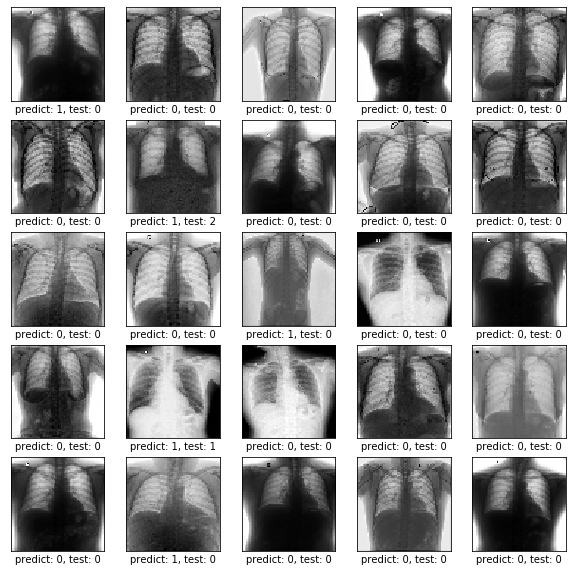

In [179]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    #idxs.append(idx)
    test_x_idx=test_x[i].reshape(64,64)/255.0
    plt.imshow(test_x_idx,cmap=plt.cm.binary)
    
    pred = model.predict(test_x[i].reshape(-1,64,64,1))
    plt.xlabel('predict: ' + str(np.argmax(pred))+ ', test: ' + str(test_y[i]))
plt.show()

Reduce the numpy array of predicted value to a list for calculating the confusion matrix.

In [139]:
reduce=[]
for a in pred_y: 
    reduce.append(np.argmax(a))

Calculate the confusion matrix for multiclass classification.

In [142]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test_y,reduce)

array([[970,  53,   9],
       [ 72, 173,  14],
       [ 15,  13,   7]])

Conclusion: 

The final LeNet-5 model has a satisfying AUC score of the test data by comparing it to the validation data and the baseline model. Specifically, the final AUC is slightly higher than the AUC of both validation data and baseline model.

Though the accuracy rate of the baseline model is slightly higher than the final concise LeNet-5 model's, the AUC is a more reliable measurement when the test data has a unbalanced distribution between each class. 

However, after we have run multiple CNN models with both LeNet-5 and VGG and fine-tune by multiple regularization methods to reduce overfitting, the most efficient way to receive a good model performance is to produce a concise model with only one layer of convolutional layer. This indicate that one-layer netural network might be powerful enough to produce a satisfying result, while most complex CNN models would suffer the overfitting issue. Therefore, I would recommend a simple and concise CNN model for classifying the x-ray images with only one black-and-white channel and relatively low resolution (64*64*1). 
